# TTI Explorer

#### `tti_explorer` is a library for simulating infection spread. This library is built to explore the impact of various test-trace-isolate strategies and social distancing measures on the spread of COVID-19 in the UK. 

This notebook is an introduction to the functionality offered by `tti-explorer`. 

In [ ]:
!git clone https://github.com/rs-delve/tti-explorer.git
%cd tti-explorer
%pip install -q .

Cloning into 'tti-explorer'...
remote: Enumerating objects: 554, done.
remote: Counting objects: 100% (554/554), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 2667 (delta 396), reused 405 (delta 277), pack-reused 2113
Receiving objects: 100% (2667/2667), 31.55 MiB | 19.15 MiB/s, done.
Resolving deltas: 100% (1909/1909), done.
/content/tti-explorer


In [ ]:
def print_doc(func):
    print(func.__doc__)

In [ ]:
%pip install gpy

     |████████████████████████████████| 1.0MB 9.1MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
  Created wheel for gpy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633919 sha256=afe7a22455a62771c51e7dc556449e46a943de71ff044b7bae012462bde63638
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102552 sha256=cfe845d2a764b8c109e52b153b5cbc0d9f7adaa83b32a429f1f3592fc2b43b56
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built gpy paramz


In [ ]:
%pip install pyDOE

  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp36-none-any.whl size=18178 sha256=4d773cadeb6117cb65f94d4a4bc3397bd6a98057e6337002a7badfd93d54b0b7
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pyDOE


In [ ]:
%pip install emukit

     |████████████████████████████████| 122kB 8.7MB/s 
     |████████████████████████████████| 31.2MB 159kB/s 
  Created wheel for emukit: filename=emukit-0.4.7-cp36-none-any.whl size=188045 sha256=52a33a064b4ea41a5d52d0eec71ac92082168213ad450b4bc1c457f372a1588d
  Stored in directory: /root/.cache/pip/wheels/37/d9/0c/31e157b6c2834699041b1b4cdf76898474c010ac53543d0611
  Created wheel for emcee: filename=emcee-2.2.1-cp36-none-any.whl size=29596 sha256=5a61543c8e4daeff20cda06dd807795218666223d0929ad94b12d5d3fc9bf889
  Stored in directory: /root/.cache/pip/wheels/2f/5d/a5/78f84e23329ad7d9b1787c9d24371100cae74cdefe25eba50d
Successfully built emukit emcee
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existin

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from tqdm.notebook import trange
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

from tti_explorer import config, utils
from tti_explorer.case import simulate_case, CaseFactors
from tti_explorer.contacts import EmpiricalContactsSimulator
from tti_explorer.strategies import TTIFlowModel, RETURN_KEYS

import numpy as np
import GPy
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.core.initial_designs import RandomDesign
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.core.constraints import NonlinearInequalityConstraint

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def load_csv(pth):
    return np.loadtxt(pth, dtype=int, skiprows=1, delimiter=",")

In [ ]:
path_to_bbc_data = os.path.join("data", "bbc-pandemic")

over18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_o18.csv"))
under18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_u18.csv"))

**Case Config**

The following are configurations for each case:

* p_under18 (float): probability of the case being under 18.
* infection_proportions (dict): probability of being symp covid neg, symp covid pos, asymp covid pos.
* p_day_noticed_symptoms (np.array[float]): distribution of day on which case notices their symptoms. (In our model this is the same as reporting symptoms.)
* inf_profile (list[float]): describe relative infectiousness of the case for each day of the infectious period. If covid=False, then the value is 0 throughout. We assume 10 days infectiousness following research paper regarding covid.

In [ ]:
case_config = {
    'p_under18': 0.21, # for sensitivity analysis, not BO 
    'infection_proportions': { # for sensitivity analysis, not BO 
        'dist': [0.8333333333333334, 0.1, 0.06666666666666667], 
        'nppl': 120
        }, 
    'p_day_noticed_symptoms': [0, # for sensitivity analysis, not BO 
                               0.25, 
                               0.25, 
                               0.2, 
                               0.1, 
                               0.05, 
                               0.05, 
                               0.05, 
                               0.05, 
                               0.0], 
    'inf_profile': [0.046966101377360424, # for sensitivity analysis, not BO 
                    0.15602255610429985, 
                    0.19829974712514023, 
                    0.18356485224565827, 
                    0.14541407040442172, 
                    0.10500447388376151, 
                    0.07130993362939089, 
                    0.04635772205156416, 
                    0.029167894888682697, 
                    0.017892648289720214]
    }

**Contact Config**

* home_sar (float): secondary attack rate for household contacts. These contacts are infected at random with attack rates given by the SARs and whether or not the case is symptomatic. If the case is COVID negative, then no contacts are infected.
* work_sar (float): secondary attack rate for contacts in the work category.
* other_sar (float): secondary attack rate for contacts in the other category.
* asymp_factor (float): factor by which to multiply the probability of secondary infection if case is asymptomatic COVID positive (more dangerous).
* period (int): duration of the simulation (days).

In [ ]:
contacts_config = {
    # for sensitivity analysis, not BO 
   'home_sar': 0.3, 
   'work_sar': 0.045, 
   'other_sar': 0.045, 
   'period': 10, # not useful
   'asymp_factor': 0.5 # not useful
   }

**Factor Config**

* app_cov (float): coverage of people using the app.
* compliance (float): probability of a traced contact isolating correctly.
* go_to_school_prob (float): fraction of school children attending school.
* wfh_prob (float): proportion of the population working from home.

In [ ]:
factor_config = {
    # for sensitivity analysis and BO
    'app_cov': 0.35, # non BO
    'compliance': 0.8, # non BO
    'go_to_school_prob': 0.5, 
    'wfh_prob': 0.45
    }

**Policy Config**

In [ ]:
policy_config = {
    # for BO
    'isolate_individual_on_symptoms':True,  # Isolate the individual after they present with symptoms
    'isolate_individual_on_positive':True,  # Isolate the individual after they test positive
    'isolate_household_on_symptoms':False,  # Isolate the household after individual present with symptoms
    'isolate_household_on_positive':True,  # Isolate the household after individual test positive
    'isolate_contacts_on_symptoms':False,  # Isolate the contacts after individual present with symptoms
    'isolate_contacts_on_positive':True,  # Isolate the contacts after individual test positive
    'test_contacts_on_positive':False,  # Do we test contacts of a positive case immediately, or wait for them to develop symptoms
    'do_symptom_testing':True,  # Test symptomatic individuals
    'do_manual_tracing':True,  # Perform manual tracing of contacts
    'do_app_tracing':True,  # Perform app tracing of contacts
    # not useful
    'fractional_infections':True,  # Include infected but traced individuals as a fraction of their infection period not isolated
    # not useful
    'testing_delay':2,  # Days delay between test and results
    'app_trace_delay':0,  # Delay associated with tracing through the app
    'manual_trace_delay':1,  # Delay associated with tracing manually
    'manual_home_trace_prob':1.0,  # Probability of manually tracing a home contact
    'manual_work_trace_prob':1.0,  # Probability of manually tracing a work contact
    'manual_othr_trace_prob':1.0,  # Probability of manually tracing an other contact
    'met_before_w':1.0,  # Probability of having met a work contact before to be able to manually trace
    'met_before_s':1.0,  # Probability of having met a school contact before to be able to manually trace
    'met_before_o':1.0,  # Probability of having met a other contact before to be able to manually trace
    'max_contacts':2e3,  # Place a limit on the number of other contacts per day
    # useful for BO
    'quarantine_length':14,  # Length of quarantine imposed on COVID cases (and household)
    # not for BO, maybe for sensitivity analysis
    'latent_period':3,  # Length of a cases incubation period (from infection to start of infectious period)
    # Parameters for CaseFactors simulation
    'app_cov':0.35,
    'compliance':0.8,  # Probability of a traced contact isolating correctly
    'go_to_school_prob':1.0,  # Fraction of school children attending school
    'wfh_prob':0.0,  # Proportion or the population working from home
    }

**Strategy Config**

In [ ]:
strategy_config = {
    'isolate_individual_on_symptoms': True, 
    'isolate_individual_on_positive': True, 
    'isolate_household_on_symptoms': True, 
    'isolate_household_on_positive': True, 
    'isolate_contacts_on_symptoms': False, 
    'isolate_contacts_on_positive': True, 
    'test_contacts_on_positive': False, 
    'do_symptom_testing': True, 
    'do_manual_tracing': True, 
    'do_app_tracing': True, 
    'fractional_infections': True, 
    'testing_delay': 2, 
    'app_trace_delay': 0, 
    'manual_trace_delay': 1, 
    'manual_home_trace_prob': 1.0, 
    'manual_work_trace_prob': 1.0, 
    'manual_othr_trace_prob': 1.0, 
    'met_before_w': 0.79, 
    'met_before_s': 0.9, 
    'met_before_o': 0.9, 
    'max_contacts': 10, 
    'quarantine_length': 14, 
    'latent_period': 3, 
    'app_cov': 0.35, 
    'compliance': 0.8
    }

variables to do Bayesian Optimisation over:

* go_to_school_prob
* wfh_prob
* isolate_individual_on_symptoms
* isolate_individual_on_positive
* isolate_household_on_symptoms
* isolate_household_on_positive
* isolate_contacts_on_symptoms
* isolate_contacts_on_positive
* test_contacts_on_positive
* do_symptom_testing
* do_manual_tracing
* do_app_tracing
* max_contacts
* quarantine_length

In [ ]:
list_of_variables_to_optimise = [
                                  'go_to_school_prob',
                                  'wfh_prob',
                                  'isolate_individual_on_symptoms',
                                  'isolate_individual_on_positive',
                                  'isolate_household_on_symptoms',
                                  'isolate_household_on_positive',
                                  'isolate_contacts_on_symptoms',
                                  'isolate_contacts_on_positive',
                                  'test_contacts_on_positive',
                                  'do_symptom_testing',
                                  'do_manual_tracing',
                                  'do_app_tracing',
                                  'max_contacts',
                                  'quarantine_length',
                                ]

In [ ]:
rng = np.random.RandomState(42)
def generate_cases(case_config, contacts_config, n_cases=10000):
  simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)
  list_of_cases = []
  list_of_contacts = []
  for _ in trange(n_cases):
    case = simulate_case(rng, **case_config)
    contacts = simulate_contacts(case, **contacts_config)
    list_of_cases.append(case)
    list_of_contacts.append(contacts)
  return list_of_cases, list_of_contacts

list_of_cases, list_of_contacts = generate_cases(case_config, contacts_config, 10000)

In [ ]:
def do_simulation_BO2(
                  list_of_cases,
                  list_of_contacts,
                  factor_config,
                  policy_config,
                  strategy_config,
                  ):
  """
  Conduct simulation.

  :param factor_config: factor configuration
  :param policy_config: policy configuration
  :param strategy_config: strategy configuration

  :return: outputs of the simulation.
  """


  outputs = list()
  tti_model = TTIFlowModel(rng, **strategy_config)
  for i in trange(len(list_of_cases)):
    case, contacts = list_of_cases[i], list_of_contacts[i]
    '''
    while contacts.n_daily['work'] < 10: # keep regen popular kids
      case = simulate_case(rng, **case_config)
      contacts = simulate_contacts(case, **contacts_config) 
    '''
    case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
    res = tti_model(case, contacts, case_factors)
    outputs.append(res)

  return outputs

Collate and average results across the cases simulated:

In [ ]:
# This cell is mosltly just formatting results...
def format_outputs(outputs):
  to_show = [
      RETURN_KEYS.base_r,
      RETURN_KEYS.reduced_r,
      RETURN_KEYS.man_trace,
      RETURN_KEYS.app_trace,
      RETURN_KEYS.tests
  ]

  # scale factor to turn simulation numbers into UK population numbers
  nppl = case_config['infection_proportions']['nppl']
  scales = [1, 1, nppl, nppl, nppl]
  results = pd.DataFrame(
      outputs
  ).mean(
      0
  ).loc[
      to_show
  ].mul(
      scales
  ).to_frame(
      name=f"Simulation results: "
  ).rename(
      index=lambda x: x + " (k per day)" if x.startswith("#") else x
  )

  results.round(1)
  return results

format_outputs(outputs)

,Simulation results:
Base R,3.940325
Effective R,1.434916
# Manual Traces (k per day),152.700000
# App Traces (k per day),21.096000
# Tests Needed (k per day),89.988000


In [ ]:
results = pd.DataFrame(outputs).mean(0)
print(results.loc["Effective R"])

1.4349161273806679
Base R                                                                3.940325
Effective R                                                           1.434916
# Manual Traces                                                       1.272500
# App Traces                                                          0.175800
# Tests Needed                                                        0.749900
# PersonDays Quarantined                                             21.405000
Has Covid                                                             0.165900
Is Symptomatic                                                        0.930200
Got tested                                                            0.749900
# Secondary Infections                                                0.653700
# Secondary Infections Prevented by Social Distancing                 0.190100
# Secondary Infections Prevented by Isolating Cases with Symptoms     0.186427
# Secondary Infections Prevented 

In [ ]:
def loss_function_BO2(x):
  y = np.zeros((x.shape[0],1))
  for i in range(x.shape[0]):
    bayesian_optimisation_variables = {
        key: value for key, value in zip(list_of_variables_to_optimise, x[i,:])
    }
    print(bayesian_optimisation_variables)

    for config in [case_config, contacts_config, factor_config, strategy_config, policy_config]:
      for key in config.keys():
        if key in bayesian_optimisation_variables:
          config[key] = bayesian_optimisation_variables[key]
          
    outputs = do_simulation_BO2(list_of_cases=list_of_cases, 
                                list_of_contacts=list_of_contacts,
                                factor_config=factor_config,
                                policy_config=policy_config,
                                strategy_config=strategy_config,
                                )
    
    results = pd.DataFrame(outputs).mean(0)
    y[i,0] = float(results.loc["Effective R"])
  return y

In [ ]:
variable_domain = [0.0,1.0]
strategy_quarantine_length_domain = [i for i in range(15)]
delay_domain = [i for i in range(8)]
max_contacts_domain = [i+1 for i in range(20)]
boolean_domain = [True, False]
'''
go_to_school_prob
wfh_prob
isolate_individual_on_symptoms
isolate_individual_on_positive
isolate_household_on_symptoms
isolate_household_on_positive
isolate_contacts_on_symptoms
isolate_contacts_on_positive
test_contacts_on_positive
do_symptom_testing
do_manual_tracing
do_app_tracing
max_contacts
quarantine_length
'''
           
space = ParameterSpace(
          [
           ContinuousParameter('go_to_school_prob', *variable_domain), 
           ContinuousParameter('wfh_prob', *variable_domain), 
           DiscreteParameter('isolate_individual_on_symptoms', boolean_domain),
           DiscreteParameter('isolate_individual_on_positive', boolean_domain),
           DiscreteParameter('isolate_household_on_symptoms', boolean_domain),
           DiscreteParameter('isolate_household_on_positive', boolean_domain),
           DiscreteParameter('isolate_contacts_on_symptoms', boolean_domain),
           DiscreteParameter('isolate_contacts_on_positive', boolean_domain),
           DiscreteParameter('test_contacts_on_positive', boolean_domain),
           DiscreteParameter('do_symptom_testing', boolean_domain),
           DiscreteParameter('do_manual_tracing', boolean_domain),
           DiscreteParameter('do_app_tracing', boolean_domain),
           DiscreteParameter('max_contacts', max_contacts_domain), 
           DiscreteParameter('quarantine_length', strategy_quarantine_length_domain), 
           ])

design = RandomDesign(space)
x = design.get_samples(10)
y = loss_function_BO2(x)

model_gpy = GPRegression(x,y)
model_emukit = GPyModelWrapper(model_gpy)
display(model_gpy)

{'go_to_school_prob': 0.6715702890045445, 'wfh_prob': 0.7808478797505198, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 4.0, 'quarantine_length': 7.0}



{'go_to_school_prob': 0.044357621573624995, 'wfh_prob': 0.5777340068414737, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 16.0, 'quarantine_length': 2.0}



{'go_to_school_prob': 0.823535499248137, 'wfh_prob': 0.8996676603520679, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 5.0, 'quarantine_length': 13.0}



{'go_to_school_prob': 0.5514139761216835, 'wfh_prob': 0.321719687003151, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 9.0, 'quarantine_length': 12.0}



{'go_to_school_prob': 0.2866713430707003, 'wfh_prob': 0.024652345350079763, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 17.0, 'quarantine_length': 6.0}



{'go_to_school_prob': 0.7159863192093263, 'wfh_prob': 0.7813475338943887, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 19.0, 'quarantine_length': 10.0}



{'go_to_school_prob': 0.36796982731407035, 'wfh_prob': 0.7269878552154962, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 20.0, 'quarantine_length': 7.0}



{'go_to_school_prob': 0.04046389371071879, 'wfh_prob': 0.42310211947269183, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 13.0, 'quarantine_length': 13.0}



{'go_to_school_prob': 0.8355705927140039, 'wfh_prob': 0.9719204622858759, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 8.0, 'quarantine_length': 3.0}



{'go_to_school_prob': 0.16853215004158595, 'wfh_prob': 0.38123790579474903, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 2.0, 'quarantine_length': 14.0}


GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [ ]:
expected_improvement = ExpectedImprovement(model = model_emukit)
bayesopt_loop = BayesianOptimizationLoop(model = model_emukit,
                                         space = space,
                                         acquisition = expected_improvement,
                                         batch_size = 1)
NUM_EPOCHS = 30
bayesopt_loop.run_loop(loss_function_BO2, NUM_EPOCHS)

Optimization restart 1/1, f = 8.497468483640114
{'go_to_school_prob': 1.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 9.479961030061501
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 10.193294934321079
{'go_to_school_prob': 1.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 10.285749766497439
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 10.627301445814425
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 8.058299290086033
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 11.8363382866981
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 12.896136561066701
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 13.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 13.584645974785767
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 7.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 13.977013753157104
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 13.888654103975863
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 12.814497999102711
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 12.89440219508922
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 13.17623837291572
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 12.697005223356545
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 12.222620423074009
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 11.60012926344897
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 10.994499183305209
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 10.398213270619515
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 9.939928130924367
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 9.500249762799797
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 8.450770732233073
{'go_to_school_prob': 1.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 10.988200115556182
{'go_to_school_prob': 1.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 10.014615399813728
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 9.70853407958451
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 8.917490146387937
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 10.210351481433882
{'go_to_school_prob': 0.0, 'wfh_prob': 0.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 16.564238311348394
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 16.6203927081116
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 7.0}



Optimization restart 1/1, f = 17.371650600041725
{'go_to_school_prob': 0.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 16.488792874466135


In [ ]:
results = bayesopt_loop.get_results()
results.minimum_location
res = {list_of_variables_to_optimise[i]: results.minimum_location[i] for i in range(len(list_of_variables_to_optimise))} 
display(res)

{'do_app_tracing': 0.0,
 'do_manual_tracing': 1.0,
 'do_symptom_testing': 1.0,
 'go_to_school_prob': 0.25911664151328384,
 'isolate_contacts_on_positive': 0.0,
 'isolate_contacts_on_symptoms': 1.0,
 'isolate_household_on_positive': 1.0,
 'isolate_household_on_symptoms': 0.0,
 'isolate_individual_on_positive': 1.0,
 'isolate_individual_on_symptoms': 0.0,
 'max_contacts': 1.0,
 'quarantine_length': 14.0,
 'test_contacts_on_positive': 0.0,
 'wfh_prob': 0.9915696331933863}

In [ ]:
results.minimum_value

0.5230723122741664

Plot results

No handles with labels found to put in legend.


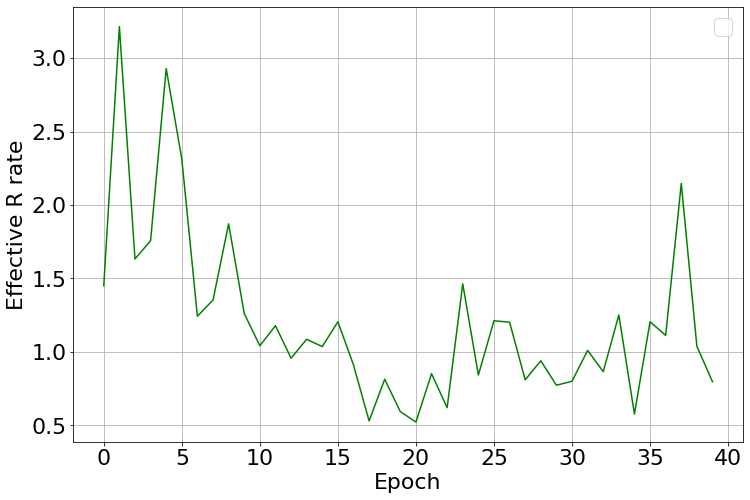

In [ ]:
# Plot function output across epochs
y = [ele[0] for ele in bayesopt_loop.model.model.Y]
x_plot = range(len(y))

plt.figure(figsize=(12, 8))
plt.plot(x_plot, y, "green")
plt.legend(loc=1)
plt.xlabel(r"Epoch")
plt.ylabel(r"Effective R rate")
plt.grid(True)
plt.show()

In [ ]:
import plotly.express as px

df = pd.DataFrame(bayesopt_loop.model.model.X, columns=list_of_variables_to_optimise)
df['Effective R'] = bayesopt_loop.model.model.Y
df_relevant = df[['go_to_school_prob', 'wfh_prob', 'do_symptom_testing','do_manual_tracing','do_app_tracing', 'max_contacts', 'quarantine_length', 'Effective R']]
#df_relevant = df[['isolate_individual_on_symptoms', 'isolate_individual_on_positive', 'isolate_household_on_symptoms','isolate_household_on_positive', 'isolate_contacts_on_symptoms', 'isolate_contacts_on_positive', 'test_contacts_on_positive', 'Effective R']]
fig = px.parallel_coordinates(df_relevant, color="Effective R", labels={
                #"go_to_school_prob": "Proportion of people \n going to school",
                #"wfh_prob": "Proportion of people working from home", 
                #"isolate_individual_on_symptoms": "Isolate Individual On Symptoms",
                #"isolate_individual_on_positive": "Isolate Individual On COVID Positive", 
                #"isolate_household_on_symptoms": "Isolate Household On Symptoms",
                #"isolate_household_on_positive": "Isolate Household On COVID Positive",
                #"isolate_contacts_on_symptoms": "Isolate Contacts On Symptoms",
                #"isolate_contacts_on_positive": "Isolate Contacts On COVID Positive",
                #"test_contacts_on_positive": "Test Contacts On COVID Positive",
                #"do_symptom_testing": "Conduct testing on Symptoms",
                "do_manual_tracing": "Manual Tracing",
                "do_app_tracing": "App Tracing",
                #"max_contacts": "Maximum contacts a person can come into",
                #"quarantine_length": "Length of Quarantine",
                },
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=2,
                )
fig.show()

Prediction of a particular strategy

In [ ]:
go_to_school_prob = 0 # @param {type:'number'}
wfh_prob = 1 # @param {type:'number'}
isolate_individual_on_symptoms = True # @param {type:"boolean"}
isolate_individual_on_positive = True # @param {type:"boolean"}
isolate_household_on_symptoms = True # @param {type:"boolean"}
isolate_household_on_positive = True # @param {type:"boolean"}
isolate_contacts_on_symptoms = True # @param {type:"boolean"}
isolate_contacts_on_positive = True # @param {type:"boolean"}
test_contacts_on_positive = True # @param {type:"boolean"}
do_symptom_testing = True # @param {type:"boolean"}
do_manual_tracing = True # @param {type:"boolean"}
do_app_tracing = True # @param {type:"boolean"}
max_contacts =   1# @param {type:"number"}
quarantine_length =   10# @param {type:"number"}

test_policy = np.array([
               go_to_school_prob,
               wfh_prob,
              isolate_individual_on_symptoms,
              isolate_individual_on_positive,
              isolate_household_on_symptoms,
              isolate_household_on_positive,
              isolate_contacts_on_symptoms,
              isolate_contacts_on_positive,
              test_contacts_on_positive,
              do_symptom_testing,
              do_manual_tracing,
              do_app_tracing,
              max_contacts,
              quarantine_length,

])
print(test_policy)

mean, var = bayesopt_loop.model.model.predict(test_policy.reshape(1,-1))

print(f"Mean Effective R: {mean}, Standard Deviation: {np.sqrt(var)}")
display(bayesopt_loop.model.model)

[ 0  1  1  1  1  1  1  1  1  1  1  1  1 10]
Mean Effective R: [[0.41997508]], Standard Deviation: [[0.07209447]]


GP_regression.,value,constraints,priors
rbf.variance,20.227898621420593,+ve,
rbf.lengthscale,16.807417243761083,+ve,
Gaussian_noise.variance,3.860572506075221e-41,+ve,


Plot effective R rate against wfh_prob

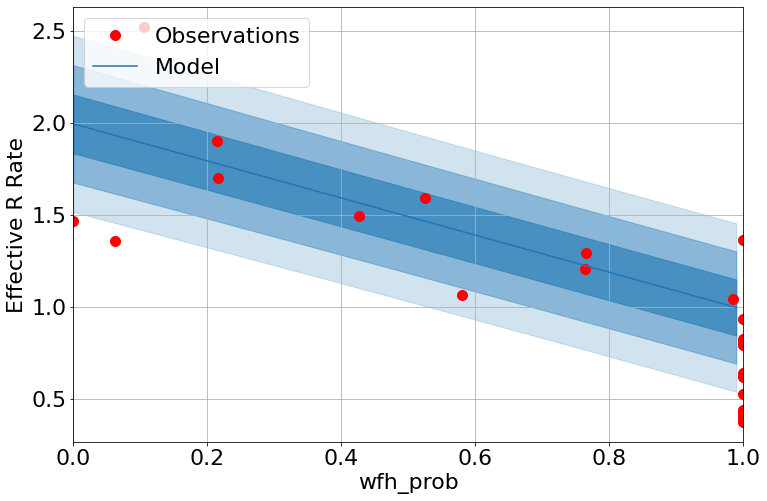

In [ ]:
wfh_prob_plot = np.arange(0.0,1.0,0.01)
x_test = []
for prob in wfh_prob_plot:
  policy = test_policy.copy()
  policy[1] = prob
  x_test.append(policy)

x_test = np.asarray(x_test).reshape(len(wfh_prob_plot), -1)
wfh_prob_plot = np.asarray(wfh_prob_plot.reshape(-1,1))
mu_plot, var_plot = bayesopt_loop.model.predict(x_test)


plt.figure(figsize=(12, 8))
plt.plot([x[1] for x in bayesopt_loop.model.model.X], bayesopt_loop.model.model.Y, "ro", markersize=10, label="Observations")
plt.plot(wfh_prob_plot, mu_plot, "C0", label="Model")
plt.fill_between(wfh_prob_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)

plt.fill_between(wfh_prob_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)

plt.fill_between(wfh_prob_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
plt.legend(loc=2)
plt.xlabel("wfh_prob")
plt.ylabel("Effective R Rate")
plt.grid(True)
plt.xlim(0, 1)

plt.show()

# Minimising number of tests, number of traces etc.

In [ ]:
# Minimise number of tests
def loss_function_BO_tests(x):
  y = np.zeros((x.shape[0],1))
  for i in range(x.shape[0]):
    bayesian_optimisation_variables = {
        key: value for key, value in zip(list_of_variables_to_optimise, x[i,:])
    }
    print(bayesian_optimisation_variables)

    for config in [case_config, contacts_config, factor_config, strategy_config, policy_config]:
      for key in config.keys():
        if key in bayesian_optimisation_variables:
          config[key] = bayesian_optimisation_variables[key]
          
    outputs = do_simulation_BO(case_config = case_config,
                               contacts_config = contacts_config,
                               factor_config = factor_config,
                               policy_config = policy_config,
                               strategy_config = strategy_config,
                               n_cases = 10000,
                               )
    
    results = pd.DataFrame(outputs).mean(0)
    y[i,0] = float(results.loc["# Tests Needed"]) * case_config['infection_proportions']['nppl']
  return y

def loss_function_BO2_tests(x):
  y = np.zeros((x.shape[0],1))
  for i in range(x.shape[0]):
    bayesian_optimisation_variables = {
        key: value for key, value in zip(list_of_variables_to_optimise, x[i,:])
    }
    print(bayesian_optimisation_variables)

    for config in [case_config, contacts_config, factor_config, strategy_config, policy_config]:
      for key in config.keys():
        if key in bayesian_optimisation_variables:
          config[key] = bayesian_optimisation_variables[key]
          
    outputs = do_simulation_BO2(list_of_cases=list_of_cases, 
                                list_of_contacts=list_of_contacts,
                                factor_config=factor_config,
                                policy_config=policy_config,
                                strategy_config=strategy_config,
                                )
    
    results = pd.DataFrame(outputs).mean(0)
    y[i,0] = float(results.loc["# Tests Needed"]) * case_config['infection_proportions']['nppl']
  return y
   
design = RandomDesign(space)
x = design.get_samples(10)
y = loss_function_BO_tests(x)

model_gpy = GPRegression(x,y)
model_emukit = GPyModelWrapper(model_gpy)
expected_improvement = ExpectedImprovement(model = model_emukit)
bayesopt_loop = BayesianOptimizationLoop(model = model_emukit,
                                         space = space,
                                         acquisition = expected_improvement,
                                         batch_size = 1)
NUM_EPOCHS = 30
bayesopt_loop.run_loop(loss_function_BO_tests, NUM_EPOCHS)

results = bayesopt_loop.get_results()
results.minimum_location
print(f"Minimum number of testing required: {results.minimum_value}")
res = {list_of_variables_to_optimise[i]: results.minimum_location[i] for i in range(len(list_of_variables_to_optimise))} 
display(res)

{'go_to_school_prob': 0.9103759356650013, 'wfh_prob': 0.7191727296265065, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 17.0, 'quarantine_length': 1.0}



{'go_to_school_prob': 0.20034314650716645, 'wfh_prob': 0.06225468547724344, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 9.0, 'quarantine_length': 6.0}



{'go_to_school_prob': 0.5886920523097604, 'wfh_prob': 0.9238317238505631, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 7.0, 'quarantine_length': 6.0}



{'go_to_school_prob': 0.07212558415686376, 'wfh_prob': 0.02224229390493071, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 11.0, 'quarantine_length': 3.0}



{'go_to_school_prob': 0.3689044904801606, 'wfh_prob': 0.3312540130328193, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 10.0}



{'go_to_school_prob': 0.8641706943468851, 'wfh_prob': 0.9176928716271123, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 5.0, 'quarantine_length': 6.0}



{'go_to_school_prob': 0.1734801746443061, 'wfh_prob': 0.7095726179911488, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 16.0, 'quarantine_length': 3.0}



{'go_to_school_prob': 0.2096574896668385, 'wfh_prob': 0.3921367288670823, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 3.0, 'quarantine_length': 8.0}



{'go_to_school_prob': 0.05577089749707631, 'wfh_prob': 0.09956125980603281, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 18.0, 'quarantine_length': 12.0}



{'go_to_school_prob': 0.5067048212930763, 'wfh_prob': 0.34840343266550766, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 9.0, 'quarantine_length': 3.0}



Optimization restart 1/1, f = 60.49659106371412
{'go_to_school_prob': 0.4420041991257683, 'wfh_prob': 0.884586932321035, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 65.93701728338299
{'go_to_school_prob': 0.21396916040672465, 'wfh_prob': 0.7461104304510812, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 71.84915362603311
{'go_to_school_prob': 0.3718937575607407, 'wfh_prob': 0.896110099629421, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 77.23817371715542
{'go_to_school_prob': 0.6208388234101114, 'wfh_prob': 0.4213949775828406, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 82.58691377416574
{'go_to_school_prob': 0.47499366571140095, 'wfh_prob': 0.9907493669245774, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 88.32638149967325
{'go_to_school_prob': 0.8601216327386022, 'wfh_prob': 0.14727603120967694, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 93.63849381381434
{'go_to_school_prob': 0.7610746787764241, 'wfh_prob': 0.6256705209364838, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 98.9142201629203
{'go_to_school_prob': 0.5182513512310905, 'wfh_prob': 0.07719517442125903, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 104.15857512625843
{'go_to_school_prob': 0.3102777534524005, 'wfh_prob': 0.1297002487469051, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 109.37475616140493
{'go_to_school_prob': 0.31975943727743583, 'wfh_prob': 0.8603092027434086, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 114.5628488547636
{'go_to_school_prob': 0.6619576482256514, 'wfh_prob': 0.5452906906715859, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 120.81361672362351
{'go_to_school_prob': 0.37598283686171763, 'wfh_prob': 0.7768142793267108, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 125.99542515433541
{'go_to_school_prob': 0.7085648088283498, 'wfh_prob': 0.43443279965451537, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 131.15352514890964
{'go_to_school_prob': 0.845910707566649, 'wfh_prob': 0.5820060163961265, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 136.28571229048708
{'go_to_school_prob': 1.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 141.39560369112587
{'go_to_school_prob': 0.9704656952578864, 'wfh_prob': 0.8652926489592826, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 146.48682167152614
{'go_to_school_prob': 0.6598523582691909, 'wfh_prob': 0.5804814839130972, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 151.5548874163057
{'go_to_school_prob': 0.7980759691961219, 'wfh_prob': 0.5426575479166352, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 156.6045558854069
{'go_to_school_prob': 0.8082899003896673, 'wfh_prob': 0.948155131132814, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 161.63078058074115
{'go_to_school_prob': 0.2637210440670673, 'wfh_prob': 0.025005100330651953, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 166.70371272541652
{'go_to_school_prob': 0.8835787038112427, 'wfh_prob': 0.6768276724324711, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 171.88011191438295
{'go_to_school_prob': 0.9845568656456657, 'wfh_prob': 0.8296105282127108, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 176.98411273496754
{'go_to_school_prob': 0.2964857093260661, 'wfh_prob': 0.13940577751322536, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 181.96101485913954
{'go_to_school_prob': 0.5415606688315185, 'wfh_prob': 0.8681673555562625, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 186.9287174735474
{'go_to_school_prob': 0.898388383617792, 'wfh_prob': 0.40831940037920633, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 194.58411022381344
{'go_to_school_prob': 0.9372247179601186, 'wfh_prob': 0.4157843054773973, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 199.60679707426348
{'go_to_school_prob': 0.39835441653394726, 'wfh_prob': 0.7530683118293282, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 204.59243461712086
{'go_to_school_prob': 0.7446050459618881, 'wfh_prob': 0.8169422304447019, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 209.5912846369807
{'go_to_school_prob': 0.023302126054420946, 'wfh_prob': 0.2640914642250066, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 214.57218681036025
{'go_to_school_prob': 0.32167218499948524, 'wfh_prob': 0.7708529591356702, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 219.53977503522964
Minimum number of testing required: 0.0


{'do_app_tracing': 0.0,
 'do_manual_tracing': 0.0,
 'do_symptom_testing': 0.0,
 'go_to_school_prob': 0.5886920523097604,
 'isolate_contacts_on_positive': 0.0,
 'isolate_contacts_on_symptoms': 0.0,
 'isolate_household_on_positive': 1.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_individual_on_positive': 1.0,
 'isolate_individual_on_symptoms': 1.0,
 'max_contacts': 7.0,
 'quarantine_length': 6.0,
 'test_contacts_on_positive': 1.0,
 'wfh_prob': 0.9238317238505631}

In [ ]:
# Minimise number of app traces
def loss_function_BO_app_traces(x):
  y = np.zeros((x.shape[0],1))
  for i in range(x.shape[0]):
    bayesian_optimisation_variables = {
        key: value for key, value in zip(list_of_variables_to_optimise, x[i,:])
    }
    print(bayesian_optimisation_variables)

    for config in [case_config, contacts_config, factor_config, strategy_config, policy_config]:
      for key in config.keys():
        if key in bayesian_optimisation_variables:
          config[key] = bayesian_optimisation_variables[key]
          
    outputs = do_simulation_BO(case_config = case_config,
                               contacts_config = contacts_config,
                               factor_config = factor_config,
                               policy_config = policy_config,
                               strategy_config = strategy_config,
                               n_cases = 10000,
                               )
    
    results = pd.DataFrame(outputs).mean(0)
    y[i,0] = float(results.loc["# App Traces"]) * case_config['infection_proportions']['nppl']
  return y

design = RandomDesign(space)
x = design.get_samples(10)
y = loss_function_BO_app_traces(x)

model_gpy = GPRegression(x,y)
model_emukit = GPyModelWrapper(model_gpy)
expected_improvement = ExpectedImprovement(model = model_emukit)
bayesopt_loop = BayesianOptimizationLoop(model = model_emukit,
                                         space = space,
                                         acquisition = expected_improvement,
                                         batch_size = 1)
NUM_EPOCHS = 30
bayesopt_loop.run_loop(loss_function_BO_app_traces, NUM_EPOCHS)

results = bayesopt_loop.get_results()
results.minimum_location
print(f"Minimum number of app traces required: {results.minimum_value}")
res = {list_of_variables_to_optimise[i]: results.minimum_location[i] for i in range(len(list_of_variables_to_optimise))} 
display(res)

{'go_to_school_prob': 0.37437353591018685, 'wfh_prob': 0.5147449057096528, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 11.0, 'quarantine_length': 7.0}



{'go_to_school_prob': 0.8021682130402694, 'wfh_prob': 0.31883699991211045, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 18.0, 'quarantine_length': 12.0}



{'go_to_school_prob': 0.10877890677588697, 'wfh_prob': 0.18444152985563056, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 15.0, 'quarantine_length': 3.0}



{'go_to_school_prob': 0.6970239951679402, 'wfh_prob': 0.8181340286352285, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 7.0, 'quarantine_length': 10.0}



{'go_to_school_prob': 0.08326155637494514, 'wfh_prob': 0.9697189508774409, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 11.0, 'quarantine_length': 4.0}



{'go_to_school_prob': 0.2963244610857302, 'wfh_prob': 0.5488733635147874, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 12.0, 'quarantine_length': 0.0}



{'go_to_school_prob': 0.6768805040674577, 'wfh_prob': 0.9084545649142283, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 10.0, 'quarantine_length': 13.0}



{'go_to_school_prob': 0.2547194409824626, 'wfh_prob': 0.9065291361118373, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 12.0, 'quarantine_length': 6.0}



{'go_to_school_prob': 0.6347813747508422, 'wfh_prob': 0.210837118073537, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 4.0, 'quarantine_length': 14.0}



{'go_to_school_prob': 0.6017713275247261, 'wfh_prob': 0.5392827173439798, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 4.0, 'quarantine_length': 12.0}



Optimization restart 1/1, f = 64.27803770937219
{'go_to_school_prob': 0.17708838058545173, 'wfh_prob': 0.9268835017477492, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 12.0, 'quarantine_length': 7.0}



Optimization restart 1/1, f = 72.76795293812259
{'go_to_school_prob': 0.49540522474078286, 'wfh_prob': 0.7814569851731602, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 12.0, 'quarantine_length': 3.0}



Optimization restart 1/1, f = 78.86867138085104
{'go_to_school_prob': 0.9562948306748699, 'wfh_prob': 0.1931010657332184, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 16.0, 'quarantine_length': 12.0}



Optimization restart 1/1, f = 84.91341246849022
{'go_to_school_prob': 0.1697121995057418, 'wfh_prob': 0.7515416933663381, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 11.0, 'quarantine_length': 13.0}



Optimization restart 1/1, f = 90.92808384618289
{'go_to_school_prob': 0.714762045098726, 'wfh_prob': 0.03623134437989395, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 17.0, 'quarantine_length': 11.0}



Optimization restart 1/1, f = 96.92099769991118
{'go_to_school_prob': 0.8124627355763046, 'wfh_prob': 0.7336754709372115, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 3.0, 'quarantine_length': 10.0}



Optimization restart 1/1, f = 102.86463202461724
{'go_to_school_prob': 0.19575767975398306, 'wfh_prob': 0.8567756308111376, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 2.0, 'quarantine_length': 12.0}



Optimization restart 1/1, f = 109.92212672646603
{'go_to_school_prob': 0.9620147063938723, 'wfh_prob': 0.14520320049424873, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 15.0, 'quarantine_length': 5.0}



Optimization restart 1/1, f = 115.8734804439514
{'go_to_school_prob': 0.42771236404952695, 'wfh_prob': 0.30082800116358843, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 3.0, 'quarantine_length': 6.0}



Optimization restart 1/1, f = 127.14336254320126
{'go_to_school_prob': 0.48119756131399727, 'wfh_prob': 0.6632257463548296, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 16.0, 'quarantine_length': 6.0}



Optimization restart 1/1, f = 133.32642198533625
{'go_to_school_prob': 0.46657901728555984, 'wfh_prob': 0.5590587705310259, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 5.0, 'quarantine_length': 9.0}



Optimization restart 1/1, f = 139.47644706750228
{'go_to_school_prob': 0.3375992638646974, 'wfh_prob': 0.5025115772339859, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 6.0, 'quarantine_length': 9.0}



Optimization restart 1/1, f = 145.6078131533352
{'go_to_school_prob': 0.0838804849420618, 'wfh_prob': 0.06673805268736277, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 18.0, 'quarantine_length': 7.0}



Optimization restart 1/1, f = 151.71318053369657
{'go_to_school_prob': 0.6041756194157163, 'wfh_prob': 0.9457442437902849, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 6.0, 'quarantine_length': 12.0}



Optimization restart 1/1, f = 157.80365919481434
{'go_to_school_prob': 0.4904789441801476, 'wfh_prob': 0.3759431149266288, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 12.0, 'quarantine_length': 5.0}



Optimization restart 1/1, f = 164.6327574276223
{'go_to_school_prob': 0.609655618476716, 'wfh_prob': 0.1583133501563666, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 12.0, 'quarantine_length': 7.0}



Optimization restart 1/1, f = 170.70675192345158
{'go_to_school_prob': 0.16376802186330852, 'wfh_prob': 0.5176948930066974, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 5.0, 'quarantine_length': 1.0}



Optimization restart 1/1, f = 180.45463983916412
{'go_to_school_prob': 0.020022514999273322, 'wfh_prob': 0.29489493453653504, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 12.0, 'quarantine_length': 9.0}



Optimization restart 1/1, f = 192.05742023337567
{'go_to_school_prob': 0.03610264843069899, 'wfh_prob': 0.9795863608516793, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 8.0, 'quarantine_length': 11.0}



Optimization restart 1/1, f = 198.41783092025096
{'go_to_school_prob': 0.40002382276615467, 'wfh_prob': 0.6187531406907832, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 7.0, 'quarantine_length': 9.0}



Optimization restart 1/1, f = 204.74820609690568
{'go_to_school_prob': 0.49884336342713387, 'wfh_prob': 0.7815526384067922, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 18.0, 'quarantine_length': 4.0}



Optimization restart 1/1, f = 211.07033265591184
{'go_to_school_prob': 0.9017008860168203, 'wfh_prob': 0.12770160370976924, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 16.0, 'quarantine_length': 4.0}



Optimization restart 1/1, f = 217.3655554424038
{'go_to_school_prob': 0.14401989663218862, 'wfh_prob': 0.785468663847379, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 10.0, 'quarantine_length': 12.0}



Optimization restart 1/1, f = 225.5402525683217
{'go_to_school_prob': 0.5549365777704129, 'wfh_prob': 0.19018964575564956, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 15.0, 'quarantine_length': 13.0}



Optimization restart 1/1, f = 231.86861256361703
{'go_to_school_prob': 0.9171972422203443, 'wfh_prob': 0.40083138675224417, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 17.0, 'quarantine_length': 2.0}



Optimization restart 1/1, f = 238.1784411208504
{'go_to_school_prob': 0.5593230180842945, 'wfh_prob': 0.5835825097096168, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 12.0}



Optimization restart 1/1, f = 244.4816661509541
{'go_to_school_prob': 0.5341614527664561, 'wfh_prob': 0.7001584440398734, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 16.0, 'quarantine_length': 7.0}



Optimization restart 1/1, f = 250.76067597501867
{'go_to_school_prob': 0.07636774515692168, 'wfh_prob': 0.125945445473718, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 17.0, 'quarantine_length': 10.0}



Optimization restart 1/1, f = 257.03560548967766
{'go_to_school_prob': 0.07922821676638092, 'wfh_prob': 0.7991652738785707, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 6.0, 'quarantine_length': 11.0}



Optimization restart 1/1, f = 263.4362029763381
{'go_to_school_prob': 0.30200728465812055, 'wfh_prob': 0.06750618596283009, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 9.0, 'quarantine_length': 7.0}



Optimization restart 1/1, f = 269.6885135732542
Minimum number of app traces required: 0.0


{'do_app_tracing': 0.0,
 'do_manual_tracing': 0.0,
 'do_symptom_testing': 0.0,
 'go_to_school_prob': 0.37437353591018685,
 'isolate_contacts_on_positive': 0.0,
 'isolate_contacts_on_symptoms': 1.0,
 'isolate_household_on_positive': 1.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_individual_on_positive': 1.0,
 'isolate_individual_on_symptoms': 0.0,
 'max_contacts': 11.0,
 'quarantine_length': 7.0,
 'test_contacts_on_positive': 1.0,
 'wfh_prob': 0.5147449057096528}

In [ ]:
# Minimise number of manual traces
def loss_function_BO_manual_traces(x):
  y = np.zeros((x.shape[0],1))
  for i in range(x.shape[0]):
    bayesian_optimisation_variables = {
        key: value for key, value in zip(list_of_variables_to_optimise, x[i,:])
    }
    print(bayesian_optimisation_variables)

    for config in [case_config, contacts_config, factor_config, strategy_config, policy_config]:
      for key in config.keys():
        if key in bayesian_optimisation_variables:
          config[key] = bayesian_optimisation_variables[key]
          
    outputs = do_simulation_BO(case_config = case_config,
                               contacts_config = contacts_config,
                               factor_config = factor_config,
                               policy_config = policy_config,
                               strategy_config = strategy_config,
                               n_cases = 10000,
                               )
    
    results = pd.DataFrame(outputs).mean(0)
    y[i,0] = float(results.loc["# Manual Traces"]) * case_config['infection_proportions']['nppl']
  return y

design = RandomDesign(space)
x = design.get_samples(10)
y = loss_function_BO_manual_traces(x)

model_gpy = GPRegression(x,y)
model_emukit = GPyModelWrapper(model_gpy)
expected_improvement = ExpectedImprovement(model = model_emukit)
bayesopt_loop = BayesianOptimizationLoop(model = model_emukit,
                                         space = space,
                                         acquisition = expected_improvement,
                                         batch_size = 1)
NUM_EPOCHS = 30
bayesopt_loop.run_loop(loss_function_BO_manual_traces, NUM_EPOCHS)

results = bayesopt_loop.get_results()
results.minimum_location
print(f"Minimum number of manual traces required: {results.minimum_value}")
res = {list_of_variables_to_optimise[i]: results.minimum_location[i] for i in range(len(list_of_variables_to_optimise))} 
display(res)

{'go_to_school_prob': 0.24107833344061336, 'wfh_prob': 0.8148468610587073, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 10.0}



{'go_to_school_prob': 0.9430268455117955, 'wfh_prob': 0.6280722174259725, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 17.0, 'quarantine_length': 12.0}



{'go_to_school_prob': 0.5750342286442125, 'wfh_prob': 0.30535314295216, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 16.0, 'quarantine_length': 13.0}



{'go_to_school_prob': 0.03682646714659921, 'wfh_prob': 0.8599070479253471, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 19.0, 'quarantine_length': 5.0}



{'go_to_school_prob': 0.6307363779337537, 'wfh_prob': 0.43801730005357464, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 13.0, 'quarantine_length': 4.0}



{'go_to_school_prob': 0.23583052993212206, 'wfh_prob': 0.07192015208678237, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 9.0, 'quarantine_length': 12.0}



{'go_to_school_prob': 0.029381907936373852, 'wfh_prob': 0.12494987132446034, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 17.0, 'quarantine_length': 14.0}



{'go_to_school_prob': 0.8500450347699617, 'wfh_prob': 0.6845663398107751, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 18.0, 'quarantine_length': 9.0}



{'go_to_school_prob': 0.858202693755305, 'wfh_prob': 0.2934692651661166, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 11.0, 'quarantine_length': 9.0}



{'go_to_school_prob': 0.15222704320263103, 'wfh_prob': 0.39949845924886607, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 19.0, 'quarantine_length': 7.0}



Optimization restart 1/1, f = 86.95531314673255
{'go_to_school_prob': 0.9693908862348346, 'wfh_prob': 0.07744776910253715, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 19.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 105.07591570581829
{'go_to_school_prob': 0.7249392350920646, 'wfh_prob': 0.8195536967599685, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 14.0, 'quarantine_length': 6.0}



Optimization restart 1/1, f = 113.20466208370917
{'go_to_school_prob': 0.22771880090840846, 'wfh_prob': 0.38957279986028137, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 18.0, 'quarantine_length': 10.0}



Optimization restart 1/1, f = 121.33340846160002
{'go_to_school_prob': 0.16645283378449482, 'wfh_prob': 0.08181103548265778, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 3.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 129.4621548394909
{'go_to_school_prob': 0.5793860011762237, 'wfh_prob': 0.08834893937321775, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 3.0, 'quarantine_length': 11.0}



Optimization restart 1/1, f = 137.59090121738177
{'go_to_school_prob': 0.019120948043241714, 'wfh_prob': 0.41974547659570116, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 13.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 145.71964759527268
{'go_to_school_prob': 0.9346298880136563, 'wfh_prob': 0.9043880231016155, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 1.0}



Optimization restart 1/1, f = 153.84839397316355
{'go_to_school_prob': 0.30969531616529455, 'wfh_prob': 0.645539458578756, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 6.0, 'quarantine_length': 7.0}



Optimization restart 1/1, f = 161.97714035105443
{'go_to_school_prob': 0.34868471057002226, 'wfh_prob': 0.12849971443519215, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 10.0, 'quarantine_length': 3.0}



Optimization restart 1/1, f = 170.10588672894528
{'go_to_school_prob': 0.18768960223188047, 'wfh_prob': 0.1096352823849277, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 9.0, 'quarantine_length': 8.0}



Optimization restart 1/1, f = 178.23463310683616
{'go_to_school_prob': 0.17656784095712752, 'wfh_prob': 0.336502122777081, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 14.0, 'quarantine_length': 6.0}



Optimization restart 1/1, f = 186.36337948472703
{'go_to_school_prob': 0.9104806088440295, 'wfh_prob': 0.8920021395432907, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 6.0, 'quarantine_length': 12.0}



Optimization restart 1/1, f = 194.49212586261788
{'go_to_school_prob': 0.7170626036760757, 'wfh_prob': 0.9799150767550254, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 10.0, 'quarantine_length': 9.0}



Optimization restart 1/1, f = 204.92865923350166
{'go_to_school_prob': 0.532804223128485, 'wfh_prob': 0.7599335875591599, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 19.0, 'quarantine_length': 13.0}



Optimization restart 1/1, f = 213.0705124728529
{'go_to_school_prob': 0.8607929846783219, 'wfh_prob': 0.8153905008595836, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 13.0, 'quarantine_length': 13.0}



Optimization restart 1/1, f = 221.53583086795842
{'go_to_school_prob': 0.260177441171619, 'wfh_prob': 0.13652975401501222, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 10.0}



Optimization restart 1/1, f = 230.46519494041473
{'go_to_school_prob': 0.1250204812165142, 'wfh_prob': 0.8120736827994718, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 19.0, 'quarantine_length': 1.0}



Optimization restart 1/1, f = 238.5939413183056
{'go_to_school_prob': 0.36086717459955253, 'wfh_prob': 0.8493833049221089, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 19.0, 'quarantine_length': 5.0}



Optimization restart 1/1, f = 246.98073322461534
{'go_to_school_prob': 0.9139641167083239, 'wfh_prob': 0.06793338063955545, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 16.0, 'quarantine_length': 10.0}



Optimization restart 1/1, f = 255.10947960250616
{'go_to_school_prob': 0.0851411158958062, 'wfh_prob': 0.5525723944807897, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 13.0, 'quarantine_length': 3.0}



Optimization restart 1/1, f = 263.23822598039703
{'go_to_school_prob': 0.079371817193166, 'wfh_prob': 0.6113515131168216, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 13.0, 'quarantine_length': 10.0}



Optimization restart 1/1, f = 271.3669723582879
{'go_to_school_prob': 0.8241524062193996, 'wfh_prob': 0.572957034553705, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 4.0, 'quarantine_length': 12.0}



Optimization restart 1/1, f = 279.49980495236133
{'go_to_school_prob': 0.6711382209478368, 'wfh_prob': 0.6680958945737215, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 6.0}



Optimization restart 1/1, f = 287.6285513302522
{'go_to_school_prob': 0.9340646241135064, 'wfh_prob': 0.4905073148717438, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 13.0, 'quarantine_length': 10.0}



Optimization restart 1/1, f = 295.7572977081431
{'go_to_school_prob': 0.36676764023743846, 'wfh_prob': 0.6364327261124031, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 5.0}



Optimization restart 1/1, f = 304.2894214853949
{'go_to_school_prob': 0.5784113383910046, 'wfh_prob': 0.9411127197176665, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 3.0, 'quarantine_length': 4.0}



Optimization restart 1/1, f = 312.4181678632858
{'go_to_school_prob': 0.9426732276916066, 'wfh_prob': 0.32131903354358593, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 18.0, 'quarantine_length': 1.0}



Optimization restart 1/1, f = 320.5579195276234
{'go_to_school_prob': 0.263239074898189, 'wfh_prob': 0.9189263144858102, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 12.0, 'quarantine_length': 6.0}



Optimization restart 1/1, f = 328.6866659055143
{'go_to_school_prob': 0.13051462443467587, 'wfh_prob': 0.4416614762076192, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 13.0, 'quarantine_length': 3.0}



Optimization restart 1/1, f = 337.28843210043976
{'go_to_school_prob': 0.09332920299765834, 'wfh_prob': 0.7146450322569324, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 13.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 345.4171784783306
Minimum number of manual traces required: 0.0


{'do_app_tracing': 1.0,
 'do_manual_tracing': 0.0,
 'do_symptom_testing': 0.0,
 'go_to_school_prob': 0.24107833344061336,
 'isolate_contacts_on_positive': 0.0,
 'isolate_contacts_on_symptoms': 1.0,
 'isolate_household_on_positive': 1.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_individual_on_positive': 0.0,
 'isolate_individual_on_symptoms': 1.0,
 'max_contacts': 1.0,
 'quarantine_length': 10.0,
 'test_contacts_on_positive': 1.0,
 'wfh_prob': 0.8148468610587073}

In [ ]:
# Minimise #PersonDays Quarantined
def loss_function_BO_persondays_quarantined(x):
  y = np.zeros((x.shape[0],1))
  for i in range(x.shape[0]):
    bayesian_optimisation_variables = {
        key: value for key, value in zip(list_of_variables_to_optimise, x[i,:])
    }
    print(bayesian_optimisation_variables)

    for config in [case_config, contacts_config, factor_config, strategy_config, policy_config]:
      for key in config.keys():
        if key in bayesian_optimisation_variables:
          config[key] = bayesian_optimisation_variables[key]
          
    outputs = do_simulation_BO(case_config = case_config,
                               contacts_config = contacts_config,
                               factor_config = factor_config,
                               policy_config = policy_config,
                               strategy_config = strategy_config,
                               n_cases = 10000,
                               )
    
    results = pd.DataFrame(outputs).mean(0)
    y[i,0] = float(results.loc["# PersonDays Quarantined"])
  return y

design = RandomDesign(space)
x = design.get_samples(10)
y = loss_function_BO_persondays_quarantined(x)

model_gpy = GPRegression(x,y)
model_emukit = GPyModelWrapper(model_gpy)
expected_improvement = ExpectedImprovement(model = model_emukit)
bayesopt_loop = BayesianOptimizationLoop(model = model_emukit,
                                         space = space,
                                         acquisition = expected_improvement,
                                         batch_size = 1)
NUM_EPOCHS = 30
bayesopt_loop.run_loop(loss_function_BO_persondays_quarantined, NUM_EPOCHS)

results = bayesopt_loop.get_results()
results.minimum_location
print(f"Minimum number of person days quarantined: {results.minimum_value}")
res = {list_of_variables_to_optimise[i]: results.minimum_location[i] for i in range(len(list_of_variables_to_optimise))} 
display(res)

{'go_to_school_prob': 0.21860004302373648, 'wfh_prob': 0.6016960101920825, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 5.0, 'quarantine_length': 6.0}



{'go_to_school_prob': 0.023983349788591957, 'wfh_prob': 0.33237772067250293, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 20.0, 'quarantine_length': 9.0}



{'go_to_school_prob': 0.5660548770564104, 'wfh_prob': 0.8889246232800475, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 15.0, 'quarantine_length': 2.0}



{'go_to_school_prob': 0.6738450954761755, 'wfh_prob': 0.13341356808769056, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 10.0, 'quarantine_length': 7.0}



{'go_to_school_prob': 0.23974329240039405, 'wfh_prob': 0.2742440593066304, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 2.0, 'quarantine_length': 9.0}



{'go_to_school_prob': 0.9357178609546125, 'wfh_prob': 0.7614729480563387, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 10.0, 'quarantine_length': 4.0}



{'go_to_school_prob': 0.5320494368381494, 'wfh_prob': 0.4144920727437028, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 7.0, 'quarantine_length': 5.0}



{'go_to_school_prob': 0.630073352470825, 'wfh_prob': 0.7039160467681795, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 13.0, 'quarantine_length': 5.0}



{'go_to_school_prob': 0.0694426809915325, 'wfh_prob': 0.13877732912671303, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 0.0}



{'go_to_school_prob': 0.9785426819609291, 'wfh_prob': 0.6681191589014401, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 2.0, 'quarantine_length': 10.0}



Optimization restart 1/1, f = 41.480242355745574
{'go_to_school_prob': 1.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 13.0, 'quarantine_length': 10.0}



Optimization restart 1/1, f = 45.36418011762784
{'go_to_school_prob': 1.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 49.09596812644344
{'go_to_school_prob': 0.0, 'wfh_prob': 0.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 53.669098329469705
{'go_to_school_prob': -2.7755575615628914e-17, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 6.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 57.31432938552847
{'go_to_school_prob': 1.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 7.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 61.02473100107043
{'go_to_school_prob': 1.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 64.40331414794544
{'go_to_school_prob': 0.0, 'wfh_prob': 0.0, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 11.0, 'quarantine_length': 6.0}



Optimization restart 1/1, f = 67.45875229219459
{'go_to_school_prob': 1.0, 'wfh_prob': 0.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 6.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 70.54231000615944
{'go_to_school_prob': 1.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 10.0, 'quarantine_length': 6.0}



Optimization restart 1/1, f = 74.05785312726566
{'go_to_school_prob': 0.0, 'wfh_prob': 0.0, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 14.0, 'quarantine_length': 7.0}



Optimization restart 1/1, f = 77.74330346033842
{'go_to_school_prob': 0.0, 'wfh_prob': 0.0, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 6.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 81.42363907285788
{'go_to_school_prob': 1.0, 'wfh_prob': 0.0, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 11.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 84.96705739356587
{'go_to_school_prob': 1.0, 'wfh_prob': 1.0, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 4.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 87.70985839081553
{'go_to_school_prob': 0.0, 'wfh_prob': 0.0, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 11.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 114.28150699903838
{'go_to_school_prob': 0.8562635169757368, 'wfh_prob': 0.5212951528325754, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 14.0, 'quarantine_length': 7.0}



Optimization restart 1/1, f = 118.55295834736121
{'go_to_school_prob': 0.9279393369758339, 'wfh_prob': 0.6049110255604898, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 18.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 122.78559482063714
{'go_to_school_prob': 0.7639078803051707, 'wfh_prob': 0.2568172046380882, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 14.0, 'quarantine_length': 3.0}



Optimization restart 1/1, f = 130.79315278411548
{'go_to_school_prob': 0.8744314979891462, 'wfh_prob': 0.9825429532480059, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 11.0, 'quarantine_length': 11.0}



Optimization restart 1/1, f = 137.28374690113864
{'go_to_school_prob': 0.6616292499409975, 'wfh_prob': 0.08181139016235339, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 6.0, 'quarantine_length': 3.0}



Optimization restart 1/1, f = 141.6791538460606
{'go_to_school_prob': 0.45199803485898393, 'wfh_prob': 0.2036524430779938, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 9.0, 'quarantine_length': 11.0}



Optimization restart 1/1, f = 146.25721823562085
{'go_to_school_prob': 0.18036545996712638, 'wfh_prob': 0.16959930813020618, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 19.0, 'quarantine_length': 11.0}



Optimization restart 1/1, f = 150.63964400357364
{'go_to_school_prob': 0.8542093001419808, 'wfh_prob': 0.5130082747528054, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 3.0, 'quarantine_length': 1.0}



Optimization restart 1/1, f = 154.99100818410034
{'go_to_school_prob': 0.9777573517161945, 'wfh_prob': 0.12685034612685864, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 12.0, 'quarantine_length': 12.0}



Optimization restart 1/1, f = 159.36048759705858
{'go_to_school_prob': 0.8430211663544157, 'wfh_prob': 0.1498115456264386, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 17.0, 'quarantine_length': 13.0}



Optimization restart 1/1, f = 163.69903087928662
{'go_to_school_prob': 0.34089960958997967, 'wfh_prob': 0.9158120322899278, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 4.0, 'quarantine_length': 3.0}



Optimization restart 1/1, f = 168.00646387020848
{'go_to_school_prob': 0.9065014143816559, 'wfh_prob': 0.7571441176891953, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 5.0, 'quarantine_length': 10.0}



Optimization restart 1/1, f = 172.31643022319912
{'go_to_school_prob': 0.8540408902454865, 'wfh_prob': 0.8395950332354571, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 16.0, 'quarantine_length': 10.0}



Optimization restart 1/1, f = 176.60825601916167
{'go_to_school_prob': 0.25567324371309585, 'wfh_prob': 0.17412629428972015, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 14.0, 'quarantine_length': 10.0}



Optimization restart 1/1, f = 180.88541561318306
{'go_to_school_prob': 0.6316281898415352, 'wfh_prob': 0.4009517262622194, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 8.0, 'quarantine_length': 11.0}



Optimization restart 1/1, f = 185.15320645400888
{'go_to_school_prob': 0.5606837671861591, 'wfh_prob': 0.7004411967993155, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 16.0, 'quarantine_length': 12.0}



Optimization restart 1/1, f = 189.39789301612632
Minimum number of person days quarantined: 0.0


{'do_app_tracing': 0.0,
 'do_manual_tracing': 0.0,
 'do_symptom_testing': 1.0,
 'go_to_school_prob': -2.7755575615628914e-17,
 'isolate_contacts_on_positive': 1.0,
 'isolate_contacts_on_symptoms': 0.0,
 'isolate_household_on_positive': 1.0,
 'isolate_household_on_symptoms': 0.0,
 'isolate_individual_on_positive': 0.0,
 'isolate_individual_on_symptoms': 0.0,
 'max_contacts': 6.0,
 'quarantine_length': 0.0,
 'test_contacts_on_positive': 0.0,
 'wfh_prob': 1.0}

#**Constrained Bayesian Optimisation**

In [ ]:
# Constraint: Minimising effective R rate, but with maximum 25,000 tests a day (Source: https://www.theguardian.com/world/2020/aug/24/coronavirus-home-test-kits-run-out-in-england-and-scotland)
def constraint_function(x):
  bayesian_optimisation_variables = {
      key: value for key, value in zip(list_of_variables_to_optimise, x)
  }
  for config in [case_config, contacts_config, factor_config, strategy_config, policy_config]:
    for key in config.keys():
      if key in bayesian_optimisation_variables:
        config[key] = bayesian_optimisation_variables[key]
        
  outputs = do_simulation_BO3(list_of_cases=list_of_cases, 
                              list_of_contacts=list_of_contacts,
                              factor_config=factor_config,
                              policy_config=policy_config,
                              strategy_config=strategy_config,
                              )
  
  results = pd.DataFrame(outputs).mean(0)
  return float(results.loc["# Tests Needed"]) * case_config['infection_proportions']['nppl'] 

def do_simulation_BO3(
                  list_of_cases,
                  list_of_contacts,
                  factor_config,
                  policy_config,
                  strategy_config,
                  ):
  outputs = list()
  tti_model = TTIFlowModel(rng, **strategy_config)
  for i in range(100):
    case, contacts = list_of_cases[i], list_of_contacts[i]
    case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
    res = tti_model(case, contacts, case_factors)
    outputs.append(res)

  return outputs

TEST_KITS_LOWER_BOUND = 5
TEST_KITS_UPPER_BOUND = 25
constraints = [NonlinearInequalityConstraint(constraint_function, TEST_KITS_LOWER_BOUND, TEST_KITS_UPPER_BOUND)]
space.constraints = constraints
  
design = RandomDesign(space)
x = design.get_samples(10)
y = loss_function_BO2(x)

model_gpy = GPRegression(x,y)
model_emukit = GPyModelWrapper(model_gpy)
expected_improvement = ExpectedImprovement(model = model_emukit)
bayesopt_loop = BayesianOptimizationLoop(model = model_emukit,
                                         space = space,
                                         acquisition = expected_improvement,
                                         batch_size = 1)
NUM_EPOCHS = 30
bayesopt_loop.run_loop(loss_function_BO2, NUM_EPOCHS)

results = bayesopt_loop.get_results()
results.minimum_location
print(f"Minimum effective R rate: {results.minimum_value}, with number of testing kits: {constraint_function(results.minimum_location)}")
res = {list_of_variables_to_optimise[i]: results.minimum_location[i] for i in range(len(list_of_variables_to_optimise))} 
display(res)

{'go_to_school_prob': 0.8144580958752892, 'wfh_prob': 0.774278059698084, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 6.0, 'quarantine_length': 11.0}



{'go_to_school_prob': 0.6581232550995949, 'wfh_prob': 0.27029236426174896, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 7.0}



{'go_to_school_prob': 0.6292168883948459, 'wfh_prob': 0.33585356831963464, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 10.0, 'quarantine_length': 13.0}



{'go_to_school_prob': 0.9726711372428193, 'wfh_prob': 0.16244996566487224, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 10.0, 'quarantine_length': 9.0}



{'go_to_school_prob': 0.4531348701055177, 'wfh_prob': 0.27957824613136084, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 11.0, 'quarantine_length': 9.0}



{'go_to_school_prob': 0.09057144580047494, 'wfh_prob': 0.07099214721257519, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 7.0, 'quarantine_length': 2.0}



{'go_to_school_prob': 0.11789104651992488, 'wfh_prob': 0.19242221525474934, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 15.0, 'quarantine_length': 9.0}



{'go_to_school_prob': 0.23604764418879853, 'wfh_prob': 0.1259550002752563, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 0.0}



{'go_to_school_prob': 0.6567469373275451, 'wfh_prob': 0.6846467829128728, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 10.0, 'quarantine_length': 9.0}



{'go_to_school_prob': 0.49400068998248725, 'wfh_prob': 0.23419961389331168, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 11.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 7.142465580012403
{'go_to_school_prob': 0.7010116980479063, 'wfh_prob': 0.1319020321181087, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 14.0, 'quarantine_length': 1.0}



Optimization restart 1/1, f = 7.2313339030759725
{'go_to_school_prob': 0.7733575028883322, 'wfh_prob': 0.3842909800636533, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 14.0, 'quarantine_length': 13.0}



Optimization restart 1/1, f = 9.155550525552346
{'go_to_school_prob': 0.3343101003678741, 'wfh_prob': 0.6050969080362785, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 6.0, 'quarantine_length': 1.0}



Optimization restart 1/1, f = 10.311350911503116
{'go_to_school_prob': 0.5249733410273768, 'wfh_prob': 0.4866505164676084, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 14.0, 'quarantine_length': 10.0}



Optimization restart 1/1, f = 10.459094684926125
{'go_to_school_prob': 0.9996719679397914, 'wfh_prob': 0.008174646356272186, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 4.0}



Optimization restart 1/1, f = 10.53607048721497
{'go_to_school_prob': 0.4265542222074483, 'wfh_prob': 0.5885142373768213, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 5.0, 'quarantine_length': 7.0}



Optimization restart 1/1, f = 10.73302238465285
{'go_to_school_prob': 0.6491890069178542, 'wfh_prob': 0.5079383977563323, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 10.0, 'quarantine_length': 11.0}



Optimization restart 1/1, f = 11.653759293861516
{'go_to_school_prob': 0.4907974260658992, 'wfh_prob': 0.49166999465307304, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 13.0, 'quarantine_length': 6.0}



Optimization restart 1/1, f = 13.895451090895856
{'go_to_school_prob': 0.6245606557627044, 'wfh_prob': 0.5885784791622085, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 12.0, 'quarantine_length': 11.0}



Optimization restart 1/1, f = 14.249255271085083
{'go_to_school_prob': 0.5109741344728008, 'wfh_prob': 0.5072660120256126, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 2.0, 'quarantine_length': 6.0}



Optimization restart 1/1, f = 14.368200115853025
{'go_to_school_prob': 0.1642735412532072, 'wfh_prob': 0.5435923486681851, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 16.0, 'quarantine_length': 11.0}



Optimization restart 1/1, f = 14.484782406253082
{'go_to_school_prob': 0.5630321156374629, 'wfh_prob': 0.5955348699923416, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 12.0, 'quarantine_length': 11.0}



Optimization restart 1/1, f = 14.844948086056245
{'go_to_school_prob': 0.5440060316571835, 'wfh_prob': 0.5549849753132396, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 18.0, 'quarantine_length': 10.0}



Optimization restart 1/1, f = 15.816598073233795
{'go_to_school_prob': 0.4957076100451464, 'wfh_prob': 0.5346027629909839, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 11.0, 'quarantine_length': 5.0}



Optimization restart 1/1, f = 16.59315487634106
{'go_to_school_prob': 0.5177002870172832, 'wfh_prob': 0.6326054591832962, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 15.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 17.38776073224233
{'go_to_school_prob': 0.878554567958511, 'wfh_prob': 0.8507525563793296, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 19.0, 'quarantine_length': 12.0}



Optimization restart 1/1, f = 17.799721985990942
{'go_to_school_prob': 0.5367227057573664, 'wfh_prob': 0.43358478921371413, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 6.0, 'quarantine_length': 1.0}



Optimization restart 1/1, f = 19.381266741312253
{'go_to_school_prob': 0.7208403759295401, 'wfh_prob': 0.5900055594755439, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 16.0, 'quarantine_length': 13.0}



Optimization restart 1/1, f = 20.24497688153515
{'go_to_school_prob': 0.4700210946119271, 'wfh_prob': 0.39908160204443927, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 19.0, 'quarantine_length': 1.0}



Optimization restart 1/1, f = 20.534663992158
{'go_to_school_prob': 0.43148576576747427, 'wfh_prob': 0.45410283819935393, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 3.0, 'quarantine_length': 9.0}



Optimization restart 1/1, f = 20.771545589132696
{'go_to_school_prob': 0.5274520150990603, 'wfh_prob': 0.538038687404819, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 13.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 21.119391048717482
{'go_to_school_prob': 0.357093129362006, 'wfh_prob': 0.04630392930121896, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 20.0, 'quarantine_length': 0.0}



Optimization restart 1/1, f = 21.537817525582742
{'go_to_school_prob': 0.5464011507902279, 'wfh_prob': 0.552365149587246, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 15.0, 'quarantine_length': 12.0}



Optimization restart 1/1, f = 22.255922289777367
{'go_to_school_prob': 0.6768801368928078, 'wfh_prob': 0.7434759017921437, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 17.0, 'quarantine_length': 9.0}



Optimization restart 1/1, f = 23.496157595086434
{'go_to_school_prob': 0.6508354357548335, 'wfh_prob': 0.47134727878805693, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 19.0, 'quarantine_length': 13.0}



Optimization restart 1/1, f = 23.825191842153433
{'go_to_school_prob': 0.29645742597248914, 'wfh_prob': 0.4450466082847498, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 16.0, 'quarantine_length': 10.0}



Optimization restart 1/1, f = 24.476648222959724
{'go_to_school_prob': 0.5085222548550287, 'wfh_prob': 0.5125267639682776, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 17.0, 'quarantine_length': 13.0}



Optimization restart 1/1, f = 24.683875663871643
{'go_to_school_prob': 0.2682755056560746, 'wfh_prob': 0.3585325506323349, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 6.0, 'quarantine_length': 13.0}



Optimization restart 1/1, f = 25.57159731653176
{'go_to_school_prob': 0.8932912724531406, 'wfh_prob': 0.9537609971788118, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 2.0, 'quarantine_length': 12.0}



Optimization restart 1/1, f = 27.844380462609415
{'go_to_school_prob': 0.3972454341689135, 'wfh_prob': 0.3565855747679205, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 12.0, 'quarantine_length': 7.0}



Optimization restart 1/1, f = 28.026899425813074
Minimum effective R rate: 0.8717791140890288, with number of testing kits: 0.0


{'do_app_tracing': 0.0,
 'do_manual_tracing': 0.0,
 'do_symptom_testing': 1.0,
 'go_to_school_prob': 0.8932912724531406,
 'isolate_contacts_on_positive': 0.0,
 'isolate_contacts_on_symptoms': 0.0,
 'isolate_household_on_positive': 0.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_individual_on_positive': 1.0,
 'isolate_individual_on_symptoms': 1.0,
 'max_contacts': 2.0,
 'quarantine_length': 12.0,
 'test_contacts_on_positive': 1.0,
 'wfh_prob': 0.9537609971788118}

Results:
```
Minimum effective R rate: 0.5552778631743174, with number of testing kits limited to: 25k per day
{'do_app_tracing': 0.0,
 'do_manual_tracing': 0.0,
 'do_symptom_testing': 0.0,
 'go_to_school_prob': 0.016584974814775055,
 'isolate_contacts_on_positive': 0.0,
 'isolate_contacts_on_symptoms': 0.0,
 'isolate_household_on_positive': 0.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_individual_on_positive': 1.0,
 'isolate_individual_on_symptoms': 1.0,
 'max_contacts': 2.0,
 'quarantine_length': 2.0,
 'test_contacts_on_positive': 1.0,
 'wfh_prob': 0.9958967315585702}
 ```

In [ ]:
# Running a simulation on the above parameters gives us:
test_policy = {'do_app_tracing': 0.0,
 'do_manual_tracing': 0.0,
 'do_symptom_testing': 0.0,
 'go_to_school_prob': 0.016584974814775055,
 'isolate_contacts_on_positive': 0.0,
 'isolate_contacts_on_symptoms': 0.0,
 'isolate_household_on_positive': 0.0,
 'isolate_household_on_symptoms': 1.0,
 'isolate_individual_on_positive': 1.0,
 'isolate_individual_on_symptoms': 1.0,
 'max_contacts': 2.0,
 'quarantine_length': 2.0,
 'test_contacts_on_positive': 1.0,
 'wfh_prob': 0.9958967315585702}

for config in [case_config, contacts_config, factor_config, strategy_config, policy_config]:
  for key in config.keys():
    if key in test_policy:
      config[key] = test_policy[key]
      
outputs = do_simulation_BO2(
    list_of_cases=list_of_cases, 
    list_of_contacts=list_of_contacts,
    factor_config=factor_config,
    policy_config=policy_config,
    strategy_config=strategy_config,
    )

print(pd.DataFrame(outputs).mean(0))

results = format_outputs(outputs)

display(results)



Base R                                                               3.869753e+00
Effective R                                                          5.734495e-01
# Manual Traces                                                      0.000000e+00
# App Traces                                                         0.000000e+00
# Tests Needed                                                       0.000000e+00
# PersonDays Quarantined                                             4.294400e+00
Has Covid                                                            1.620000e-01
Is Symptomatic                                                       9.350000e-01
Got tested                                                           0.000000e+00
# Secondary Infections                                               6.269000e-01
# Secondary Infections Prevented by Social Distancing                4.675000e-01
# Secondary Infections Prevented by Isolating Cases with Symptoms    6.650117e-02
# Secondary Inf

,Simulation results:
Base R,3.869753
Effective R,0.573450
# Manual Traces (k per day),0.000000
# App Traces (k per day),0.000000
# Tests Needed (k per day),0.000000


#**Ablation Study on Acquisition Functions**

{'go_to_school_prob': 0.08944571398711976, 'wfh_prob': 0.23288568774256724, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 11.0, 'quarantine_length': 7.0}



{'go_to_school_prob': 0.6470327651378339, 'wfh_prob': 0.48380760208584306, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 16.0, 'quarantine_length': 4.0}



{'go_to_school_prob': 0.6643598924950385, 'wfh_prob': 0.881704685034635, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 8.0, 'quarantine_length': 10.0}



{'go_to_school_prob': 0.10362687780193036, 'wfh_prob': 0.37011907336251804, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 10.0, 'quarantine_length': 5.0}



{'go_to_school_prob': 0.186893906652007, 'wfh_prob': 0.777540993340914, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 13.0, 'quarantine_length': 4.0}



{'go_to_school_prob': 0.6733629686822218, 'wfh_prob': 0.9322642087239296, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 10.0, 'quarantine_length': 9.0}



{'go_to_school_prob': 0.09146911429238502, 'wfh_prob': 0.5561754810474034, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 2.0, 'quarantine_length': 3.0}



{'go_to_school_prob': 0.449666719914666, 'wfh_prob': 0.9457202329858598, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 3.0, 'quarantine_length': 13.0}



{'go_to_school_prob': 0.3345384040877686, 'wfh_prob': 0.1789758347714444, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 20.0, 'quarantine_length': 0.0}



{'go_to_school_prob': 0.7171609323560711, 'wfh_prob': 0.8427269018341494, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 17.0, 'quarantine_length': 4.0}



Optimization restart 1/1, f = 9.022649856547556
{'go_to_school_prob': 0.555386799305869, 'wfh_prob': 0.6253645030017785, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 9.244614600507168
{'go_to_school_prob': 0.3164901464869717, 'wfh_prob': 0.3649069562657491, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 9.365041202701253
{'go_to_school_prob': 0.8643734495500588, 'wfh_prob': 0.8932874569116181, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 9.457090209006077
{'go_to_school_prob': 0.6770870653768553, 'wfh_prob': 0.9631030466784567, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 9.60185970836369
{'go_to_school_prob': 0.24706818959592258, 'wfh_prob': 0.3363377455175868, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 9.934989454566558
{'go_to_school_prob': 0.012398507741015807, 'wfh_prob': 0.3983454712707324, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 9.911376437444712
{'go_to_school_prob': 0.4431135912678924, 'wfh_prob': 0.9837903094913515, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 10.116816982948631
{'go_to_school_prob': 0.723411611019238, 'wfh_prob': 0.48959044038468513, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 10.550752444421493
{'go_to_school_prob': 0.9988317301799339, 'wfh_prob': 0.30548830182507514, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 12.579753960557115
{'go_to_school_prob': 0.6810298545872959, 'wfh_prob': 0.5228220694345085, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 12.580421504187894
{'go_to_school_prob': 0.8089728271517331, 'wfh_prob': 0.8274645896132296, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 12.940461513466241
{'go_to_school_prob': 0.36700373684461784, 'wfh_prob': 0.940281189505585, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 13.41632751457689
{'go_to_school_prob': 0.6414663148080183, 'wfh_prob': 0.5289759794807246, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 13.420867757744686
{'go_to_school_prob': 0.14130308291358673, 'wfh_prob': 0.3730747506114629, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 13.321602684606102
{'go_to_school_prob': 0.9604231247522795, 'wfh_prob': 0.36951581473322315, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 13.742126517172121
{'go_to_school_prob': 0.9270273961682417, 'wfh_prob': 0.6078144222477688, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 15.164867505569678
{'go_to_school_prob': 0.24886842500110296, 'wfh_prob': 0.4528327586505423, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 15.076392384111807
{'go_to_school_prob': 0.5398471616731642, 'wfh_prob': 0.9280947942033572, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 15.842008225555245
{'go_to_school_prob': 0.10918439224773224, 'wfh_prob': 0.5832214162615516, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 13.186899362140002
{'go_to_school_prob': 0.32635861797857113, 'wfh_prob': 0.9785387110620074, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 13.0}



Optimization restart 1/1, f = 13.20849524314919
{'go_to_school_prob': 0.2463156940800031, 'wfh_prob': 0.8671553408565851, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 12.163529574091669
{'go_to_school_prob': 0.49412299838850726, 'wfh_prob': 0.41395823542079324, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 11.533109241026182
{'go_to_school_prob': 0.055414378310920775, 'wfh_prob': 0.13545769007701325, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 10.449079131674427
{'go_to_school_prob': 0.9321480795577141, 'wfh_prob': 0.9535590203954061, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 9.87746134865544
{'go_to_school_prob': 0.7240753986567489, 'wfh_prob': 0.4506211450313752, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 8.760312216674599
{'go_to_school_prob': 0.8501775705216171, 'wfh_prob': 0.4888945835905274, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 7.454613722882957
{'go_to_school_prob': 0.2502322207003872, 'wfh_prob': 0.7785201198899324, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 6.800226980698017
{'go_to_school_prob': 0.7224364627831538, 'wfh_prob': 0.21414803033453433, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 5.878861182515255
{'go_to_school_prob': 0.4030542821262929, 'wfh_prob': 0.24814696223178534, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 4.615298961871261
{'go_to_school_prob': 0.9890461509620198, 'wfh_prob': 0.907534498223754, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 3.6430609470387836
{'go_to_school_prob': 0.47068607978910393, 'wfh_prob': 0.28642919324074534, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 13.0, 'quarantine_length': 4.0}



{'go_to_school_prob': 0.302827297901465, 'wfh_prob': 0.8923909448327666, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 9.0, 'quarantine_length': 3.0}



{'go_to_school_prob': 0.43287561549638787, 'wfh_prob': 0.5332622579402828, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 9.0, 'quarantine_length': 8.0}



{'go_to_school_prob': 0.4615003510187611, 'wfh_prob': 0.947851668873923, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 13.0, 'quarantine_length': 0.0}



{'go_to_school_prob': 0.4263688903694951, 'wfh_prob': 0.48927243223919836, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 15.0, 'quarantine_length': 8.0}



{'go_to_school_prob': 0.9613021465960377, 'wfh_prob': 0.18914363656742084, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 8.0, 'quarantine_length': 11.0}



{'go_to_school_prob': 0.8956811333673383, 'wfh_prob': 0.6955768862734364, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 5.0, 'quarantine_length': 14.0}



{'go_to_school_prob': 0.630613742961896, 'wfh_prob': 0.33176095051084686, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 10.0}



{'go_to_school_prob': 0.5097009095352774, 'wfh_prob': 0.513791226467404, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 16.0, 'quarantine_length': 10.0}



{'go_to_school_prob': 0.8838188657287981, 'wfh_prob': 0.4997096112369278, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 15.0, 'quarantine_length': 8.0}



Optimization restart 1/1, f = 10.358556577431461
{'go_to_school_prob': 0.44607563623805524, 'wfh_prob': 0.12797752159752995, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 10.802696032957058
{'go_to_school_prob': 0.7431919158449747, 'wfh_prob': 0.636494501862963, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 12.070643821026897
{'go_to_school_prob': 0.32448157926867727, 'wfh_prob': 0.1446941217793103, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 12.492202574286068
{'go_to_school_prob': 0.5550396614727665, 'wfh_prob': 0.04865123550225159, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 13.1781832563715
{'go_to_school_prob': 0.2705724027644547, 'wfh_prob': 0.7831403977988023, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 14.127548583450073
{'go_to_school_prob': 0.12612111076375787, 'wfh_prob': 0.961405685107788, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 15.736240340539004
{'go_to_school_prob': 0.9245425915852353, 'wfh_prob': 0.8942389487210399, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 16.5613405876737
{'go_to_school_prob': 0.0337464696188875, 'wfh_prob': 0.09057377758658458, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 16.964118341048632
{'go_to_school_prob': 0.41807347450430354, 'wfh_prob': 0.4067182811893867, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 17.412962331438134
{'go_to_school_prob': 0.025271492072231894, 'wfh_prob': 0.3868522782602216, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 17.716192471211517
{'go_to_school_prob': 0.36544357308998054, 'wfh_prob': 0.4319441267054849, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 18.234841758604986
{'go_to_school_prob': 0.727075118930973, 'wfh_prob': 0.9244826766298265, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 19.28667840854907
{'go_to_school_prob': 0.5900598657973682, 'wfh_prob': 0.7392258741582012, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 19.75299490403137
{'go_to_school_prob': 0.20737040440420362, 'wfh_prob': 0.1743742286171316, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 20.04400670551457
{'go_to_school_prob': 0.32327443960224655, 'wfh_prob': 0.2453671334212837, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 20.289832490950555
{'go_to_school_prob': 0.6690937967727858, 'wfh_prob': 0.5495547270249417, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 20.643397184969942
{'go_to_school_prob': 0.22352002969629148, 'wfh_prob': 0.6148354642459201, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 20.970845019640215
{'go_to_school_prob': 0.39742734655331124, 'wfh_prob': 0.7288533880597112, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 21.697864549671557
{'go_to_school_prob': 0.028214241406158136, 'wfh_prob': 0.5819980113743622, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 22.086299605574848
{'go_to_school_prob': 0.1500490844479463, 'wfh_prob': 0.2580699686428227, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 22.265727333124346
{'go_to_school_prob': 0.36350362946479053, 'wfh_prob': 0.6090072535416381, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 13.0}



Optimization restart 1/1, f = 22.714421600381286
{'go_to_school_prob': 0.20939970011590558, 'wfh_prob': 0.6302353562778088, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 22.9746583283922
{'go_to_school_prob': 0.1973875337306965, 'wfh_prob': 0.33640422335869125, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 23.203018011593425
{'go_to_school_prob': 0.4238075973053571, 'wfh_prob': 0.8132037295797387, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 23.666438256534185
{'go_to_school_prob': 0.9334841793271905, 'wfh_prob': 0.10132736397615061, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 24.206318070864707
{'go_to_school_prob': 0.4783943419866751, 'wfh_prob': 0.9032588602631793, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 24.99251266051617
{'go_to_school_prob': 0.2005105082197305, 'wfh_prob': 0.4244245969578988, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 25.119030135307103
{'go_to_school_prob': 0.1987432920467762, 'wfh_prob': 0.7820728399912286, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 25.753453511911193
{'go_to_school_prob': 0.1470854861171046, 'wfh_prob': 0.9902700857062273, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 27.34764730612682
{'go_to_school_prob': 0.06550968228922838, 'wfh_prob': 0.9524573404072093, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 28.49871346988187
{'go_to_school_prob': 0.5361005652189816, 'wfh_prob': 0.469954284974187, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 5.0, 'quarantine_length': 10.0}



{'go_to_school_prob': 0.6839922172373623, 'wfh_prob': 0.3276558130719083, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 15.0, 'quarantine_length': 2.0}



{'go_to_school_prob': 0.15829316527458914, 'wfh_prob': 0.7092927059928656, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 13.0, 'quarantine_length': 10.0}



{'go_to_school_prob': 0.14046764123038047, 'wfh_prob': 0.3261413110314375, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 8.0, 'quarantine_length': 7.0}



{'go_to_school_prob': 0.9472433352669719, 'wfh_prob': 0.5599028417830408, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 3.0, 'quarantine_length': 3.0}



{'go_to_school_prob': 0.6777884275028782, 'wfh_prob': 0.8482151555389716, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 12.0, 'quarantine_length': 7.0}



{'go_to_school_prob': 0.7153905053542706, 'wfh_prob': 0.5079513135364008, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 4.0, 'quarantine_length': 13.0}



{'go_to_school_prob': 0.14460437289253847, 'wfh_prob': 0.03144438762283619, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 16.0, 'quarantine_length': 8.0}



{'go_to_school_prob': 0.3797311834188055, 'wfh_prob': 0.4415845776836905, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 20.0, 'quarantine_length': 11.0}



{'go_to_school_prob': 0.7024814582069342, 'wfh_prob': 0.5518252932085621, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 18.0, 'quarantine_length': 5.0}



Optimization restart 1/1, f = 5.39664455071574
{'go_to_school_prob': 0.14168043542079778, 'wfh_prob': 0.8077210997646482, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 8.476231924034245
{'go_to_school_prob': 0.35763876780937554, 'wfh_prob': 0.32553185791811023, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 8.810949605388261
{'go_to_school_prob': 0.6489381440006481, 'wfh_prob': 0.008938996261584231, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 13.0}



Optimization restart 1/1, f = 8.854944606045901
{'go_to_school_prob': 0.14269701304594273, 'wfh_prob': 0.9548975135361594, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 11.681203954629243
{'go_to_school_prob': 0.49823384149392336, 'wfh_prob': 0.8610413844426674, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 13.20358608230613
{'go_to_school_prob': 0.7725108889894335, 'wfh_prob': 0.0012970815983691653, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 14.659145108114405
{'go_to_school_prob': 0.7564261979722211, 'wfh_prob': 0.09111674443081752, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 14.94449315061758
{'go_to_school_prob': 0.039375166611524626, 'wfh_prob': 0.8571482420201071, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 15.90771503346019
{'go_to_school_prob': 0.14470861905621246, 'wfh_prob': 0.36172071540816875, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 16.30097894817363
{'go_to_school_prob': 0.48621180967309396, 'wfh_prob': 0.4886786491718531, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 16.596628883563042
{'go_to_school_prob': 0.714008985689664, 'wfh_prob': 0.7306559690222564, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 16.992755443333273
{'go_to_school_prob': 0.34369005551899445, 'wfh_prob': 0.8960236558129218, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 18.42062669905649
{'go_to_school_prob': 0.3337514559694956, 'wfh_prob': 0.09909844496875642, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 18.66327655913414
{'go_to_school_prob': 0.02224340428321736, 'wfh_prob': 0.9183089076449262, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 20.353818360861602
{'go_to_school_prob': 0.16029087848323975, 'wfh_prob': 0.6680409390078891, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 21.20823709309466
{'go_to_school_prob': 0.2556720814890542, 'wfh_prob': 0.6844809236015074, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 21.95621472833554
{'go_to_school_prob': 0.48248894906333273, 'wfh_prob': 0.689594469851666, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 22.44918472052575
{'go_to_school_prob': 0.693892462466163, 'wfh_prob': 0.8303430923354829, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 23.1328885847903
{'go_to_school_prob': 0.5326253095255284, 'wfh_prob': 0.7882358675176492, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 23.677162121714538
{'go_to_school_prob': 0.14750865171843386, 'wfh_prob': 0.7419040287964355, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 24.494493358766604
{'go_to_school_prob': 0.7028349778626246, 'wfh_prob': 0.28535490107721007, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 0.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 24.77210447732534
{'go_to_school_prob': 0.8689666321289069, 'wfh_prob': 0.3083765830070777, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 25.071158421282767
{'go_to_school_prob': 0.24255227762708043, 'wfh_prob': 0.5108548914435554, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 26.011859476888226
{'go_to_school_prob': 0.8939853244614103, 'wfh_prob': 0.08959405780664575, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 27.409175632436643
{'go_to_school_prob': 0.19047245945243751, 'wfh_prob': 0.8955952450404768, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 13.0}



Optimization restart 1/1, f = 28.702248377099345
{'go_to_school_prob': 0.8160717698070015, 'wfh_prob': 0.430339044032778, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 1.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 0.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 29.031342675622163
{'go_to_school_prob': 0.542518774064545, 'wfh_prob': 0.2771518005350855, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 0.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 29.280399924441983
{'go_to_school_prob': 0.19188258080639642, 'wfh_prob': 0.4710201010230467, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 0.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 0.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 0.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 29.73657806477577
{'go_to_school_prob': 0.31364091949705897, 'wfh_prob': 0.28042937284799574, 'isolate_individual_on_symptoms': 0.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 1.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 0.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 29.968255313771657
{'go_to_school_prob': 0.6033412638343447, 'wfh_prob': 0.9464849782114704, 'isolate_individual_on_symptoms': 1.0, 'isolate_individual_on_positive': 1.0, 'isolate_household_on_symptoms': 0.0, 'isolate_household_on_positive': 1.0, 'isolate_contacts_on_symptoms': 1.0, 'isolate_contacts_on_positive': 0.0, 'test_contacts_on_positive': 1.0, 'do_symptom_testing': 1.0, 'do_manual_tracing': 1.0, 'do_app_tracing': 1.0, 'max_contacts': 1.0, 'quarantine_length': 14.0}



Optimization restart 1/1, f = 31.244032811132847


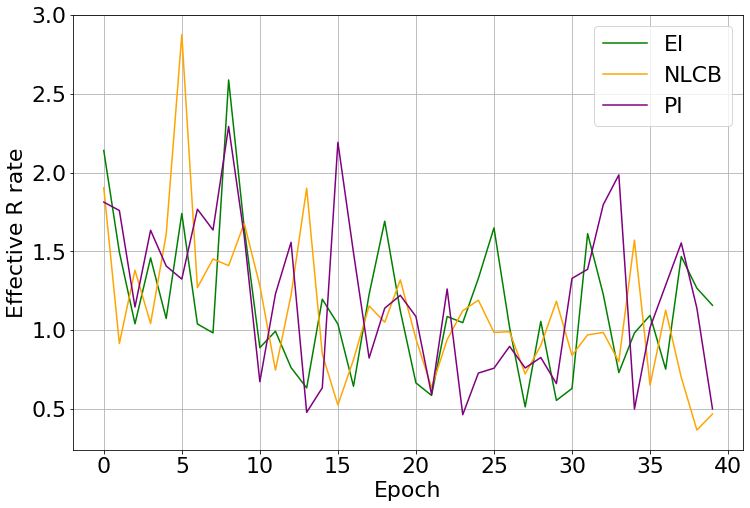

In [ ]:
ei_acquisition = ExpectedImprovement(model_emukit)
nlcb_acquisition = NegativeLowerConfidenceBound(model_emukit)
pi_acquisition = ProbabilityOfImprovement(model_emukit)

results = []

for acquisition_function in [ei_acquisition, nlcb_acquisition, pi_acquisition]:
  design = RandomDesign(space)
  x = design.get_samples(10)
  y = loss_function_BO(x)

  model_gpy = GPRegression(x,y)
  model_emukit = GPyModelWrapper(model_gpy)
  bayesopt_loop = BayesianOptimizationLoop(model = model_emukit,
                                          space = space,
                                          acquisition = acquisition_function,
                                          batch_size = 1)
  bayesopt_loop.run_loop(loss_function_BO, NUM_EPOCHS)
  result = [ele[0] for ele in bayesopt_loop.model.model.Y]
  results.append(result)

x_plot = range(len(results[0]))

plt.figure(figsize=(12, 8))
plt.plot(x_plot, results[0], "green", label="EI")
plt.plot(x_plot, results[1], "orange", label="NLCB")
plt.plot(x_plot, results[2], "purple", label="PI")
plt.legend(loc=1)
plt.xlabel(r"Epoch")
plt.ylabel(r"Effective R rate")
plt.grid(True)
plt.show()
